In [1]:
import os.path as op
import sys

sys.path.append(op.abspath('../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../')

# Cut approach

In this notebook, cuts are applied to find signal. In a previous notebook, the cuts which were applied were:
- `max_m_mean > 5`
- `min_std_pos_neg_redpn > 0.02`

We seek to replace the cuts based on amplitude, that is, the `max_m_mean > 5` cut.

## Libraries

In [2]:
import itertools

import numpy as np

from lib import plot as lp, rootdata as lrd, data, clustering

from project import defs, files, col

## Load ROOT file

In [7]:
columns_already_computed = [
    'pos_max', 'pos_min',
    'std', 'pedestal',
    'std_pos', 'std_neg',
    'max', 'min', 'mean',
]

columns_to_compute = [
    'mean_m_pedestal',
    'min_m_pedestal',
    'max_m_pedestal',
    'min_std_pos_neg',
    'max_std_pos_neg',
    'min_std_pos_neg_red',
    'max_std_pos_neg_red',
    'min_std_pos_neg_redpn',
    
    'max_m_mean',
    'max_m_mean_red',
    'min_m_mean', 'min_m_mean_red'
    
]

new_columns = ['mean_before_end_peak', 'mean_after_end_peak', 'pos_first_neg_after_max']

In [8]:
config_name = "BDT_SN"
file_path = files.get_path_processed_root(config_name)
dataframe = lrd.load_ROOT_into_dataframe(
    file_path,
    tree_name=defs.proc_tree_name,
    variables=columns_already_computed+defs.list_samples_columns,
    # cut="std!=0"
)

Time taken to load the ROOT files: 11.867511749267578
ROOT files loaded: /mnt/d/900GeV/processed/simulation/BDT_SN.root


In [9]:
dataframe = dataframe.query("std!=0")

In [10]:
files.compute_peak_voi(dataframe, zero_column="mean", red=True) 
files.compute_threshold_voi(dataframe, ref_column="min", threshold=0.7) 

# Get the formula of the columns to compute
formula_columns = col.get_formula_columns(columns_to_compute)
formula_column_labels = col.get_formula_labels(
    columns_to_compute, defs.column_labels
)
column_labels = {**defs.column_labels, **formula_column_labels}

# Compute them
dataframe = data.compute_vals(dataframe, formula_columns)

Time taken: 1.3678991794586182
Time taken: 5.595297574996948


## Cuts

In [11]:
dataframe_wh_peak = dataframe.query("min_std_pos_neg_redpn > 0.02")

## Let's define the new variables

### `nb_ampl_sup_67`

It's the number of discretised instants $t_i$ whose values are above 67\% of the amplitude of the signal.
Defining this variable w.r.t. the minimum allows not be dependent on pedestals not at a true zero, and on minimums different from the true pedestal (e.g., peaked background).

### `std_ampl_sup_67`

It is based on the same principle as the `nb_ampl_sup_67` variable, except that the mean of the squared values w.r.t to the 67% threshold is computed. This penalises large amplitudes.

### `s{i}_prop_wrt_ampl`

To define all these new variables, the variable `s{i}_prop_wrt_ampl` is defined for each sample. It corresponds to the `samples` values, expressed in proportion of amplitude. For instance, the maximum sample will be 1, and the minimum 0.

These new variables fairly increase the amount of RAM needed.

In [12]:
import pandas as pd

def define_prop_wrt_min(dataframe: pd.DataFrame):
    """ Define the variable `prop_wrt_min` in
    a dataframe. In-place.

    Args:
        dataframe: a dataframe containing the
            32 samples `s{i}`, the `max` and the
            `min` value
    """
    for i in range(defs.n_samples):
        dataframe[f"s{i}_prop_wrt_min"] = (dataframe[f"s{i}"] - dataframe["min"]) \
            / (dataframe["max"] - dataframe["min"])

In [17]:
define_prop_wrt_min(dataframe_wh_peak)

/tmp/ipykernel_27254/1270620331.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[f"s{i}_prop_wrt_min"] = (dataframe[f"s{i}"] - dataframe["min"]) \


In [18]:
def define_new_voi_wrt_ampl(dataframe: pd.DataFrame, prop: float):
    """ Define new variables of interest. These are
    computed with the `s{i}_prop_wrt_ampl` variables.

    Args:
        dataframe: dataframe containing the 32
            `"s{i}_prop_wrt_ampl` and `"s{i}"`
            variables

        prop: proportion of events considered as a threshold.
    """

    prop_percent = round(prop * 100)

    list_prop_columns = [f"{si}_prop_wrt_min" for si in defs.list_samples_columns]
    prop_array = np.array(dataframe[list_prop_columns])
    values_array = np.array(dataframe[defs.list_samples_columns])
    values_array[prop_array < prop] = 0.
    prop_array[prop_array < prop] = 0.

    dataframe[f"nb_sup_{prop_percent}"] = np.count_nonzero(values_array, axis=1)
    dataframe[f"std_sup_{prop_percent}"] = np.sum(
        np.square((prop_array - prop) / (1 - prop)), axis = 1
    ) / len(list_prop_columns)
    # We defined `normalised_prop = (prop_value - prop) / (1 - prop)` and computed the
    # its mean square value

In [19]:
define_new_voi_wrt_ampl(dataframe_wh_peak, prop=0.7)

/tmp/ipykernel_27254/240493151.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[f"nb_sup_{prop_percent}"] = np.count_nonzero(values_array, axis=1)
/tmp/ipykernel_27254/240493151.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[f"std_sup_{prop_percent}"] = np.sum(


In [27]:
prop_percent = 70
cut_variables = [
    # "min_std_pos_neg_redpn",
    "pos_max",
    # "nb_max",
    f"nb_sup_{prop_percent}",
    f"std_sup_{prop_percent}",
    f"nb_peaks_sup_{prop_percent}_wrt_min",
    "max_m_mean_red",
    "min_m_mean_red",
    'mean_before_end_peak', 'mean_after_end_peak'
]

column_labels[f"nb_sup_{prop_percent}"] = f"$\\# [p_e > {prop_percent}\\%]$"
column_labels[f"std_sup_{prop_percent}"] = f"$\\sigma[p_e > {prop_percent}\\%]$"
column_labels[f"nb_peaks_sup_{prop_percent}_wrt_min"] = f"$\\# \\text{{peaks}}[p_e > {prop_percent}\\%]$"

## Plots plots

In [31]:
column_ranges = {
    'pos_max': [0, 31],
    'nb_max': [0, 31],
    f'nb_sup_{prop_percent}': [0, 31], 
    f'nb_peaks_sup_{prop_percent}_wrt_min': [0, 31], 
}
column_nbins = {
    'default': 20,
    'nb_max': 32,
    'pos_max': 32,
    f'nb_sup_{prop_percent}': 32,
    f'nb_peaks_sup_{prop_percent}_wrt_min': 32
}

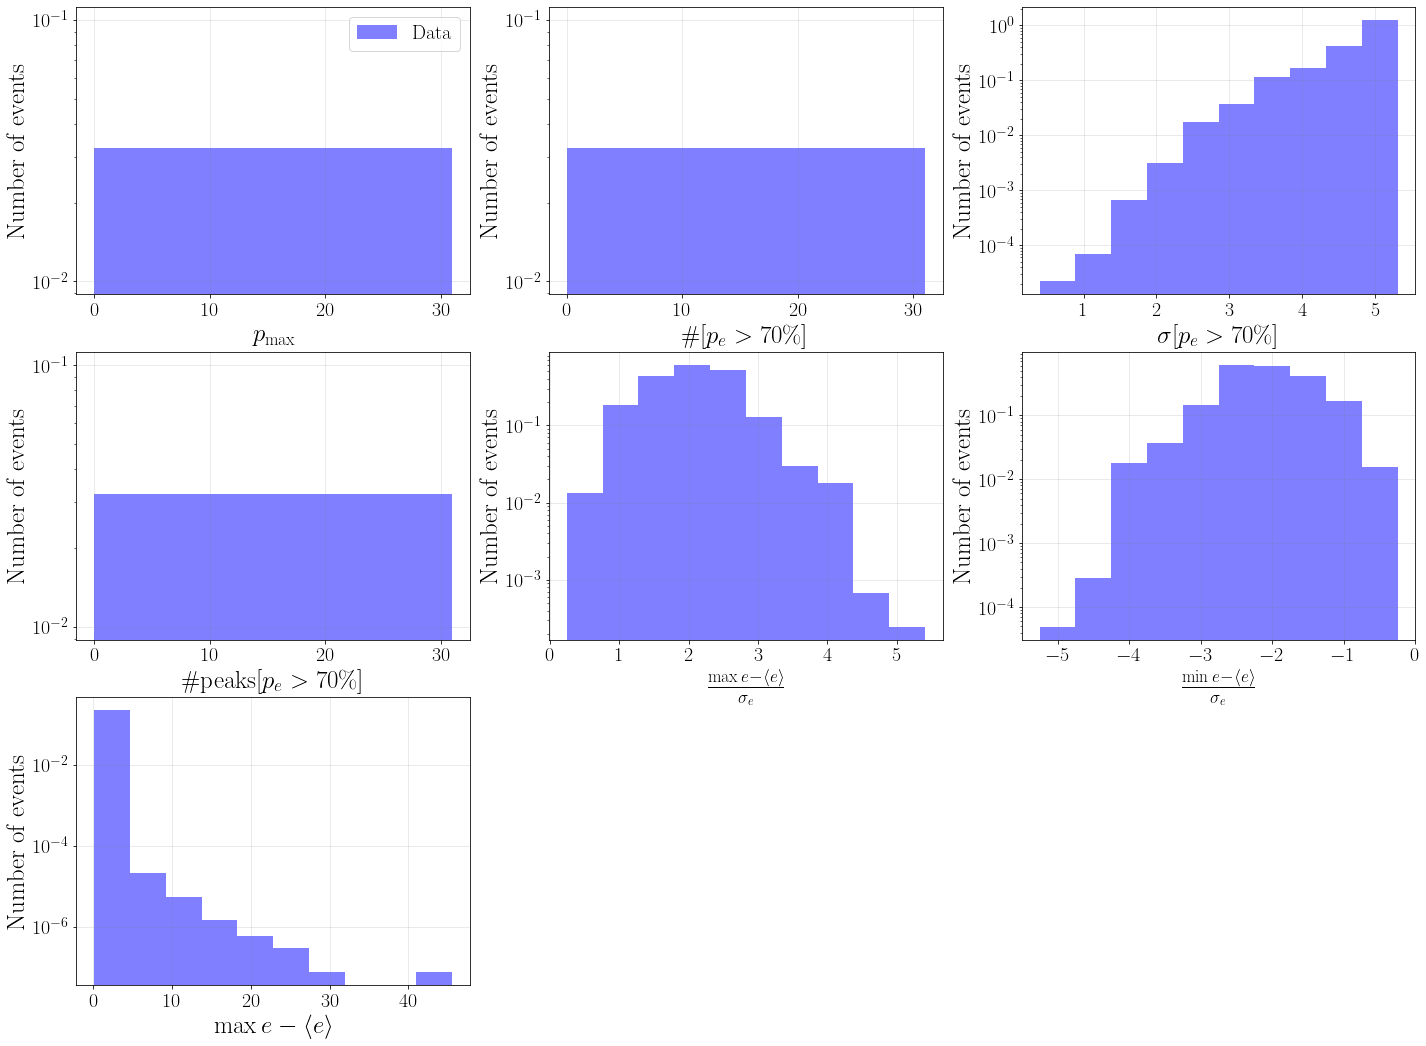

In [32]:
fig, axes = lp.multi_plot_hist(
    [dataframe_wh_peak], 
    cut_variables + ["max_m_mean"],
    column_labels,
    list_colors=['b'],
    list_labels=['Data'],
    logscale=True,
    nbins=column_ranges,
    range_columns=column_nbins
)

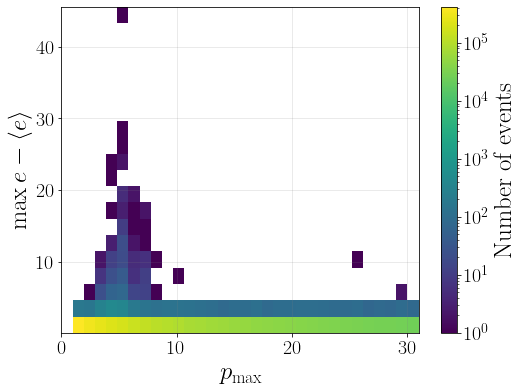

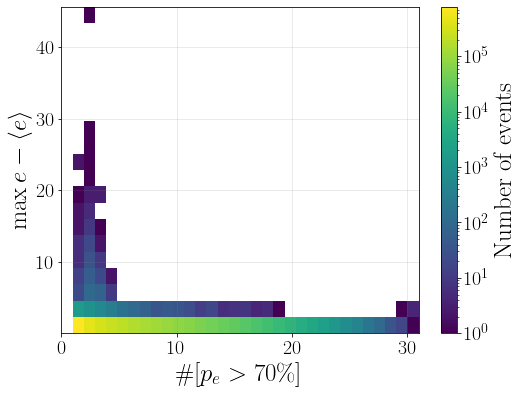

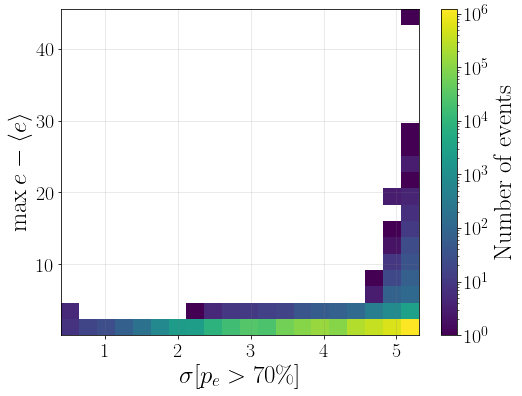

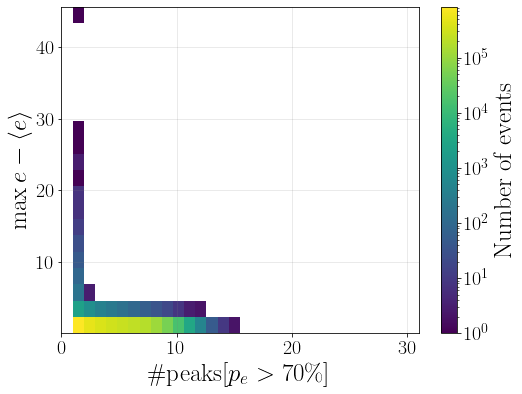

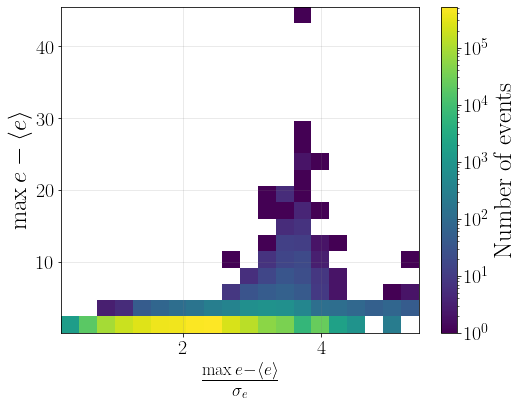

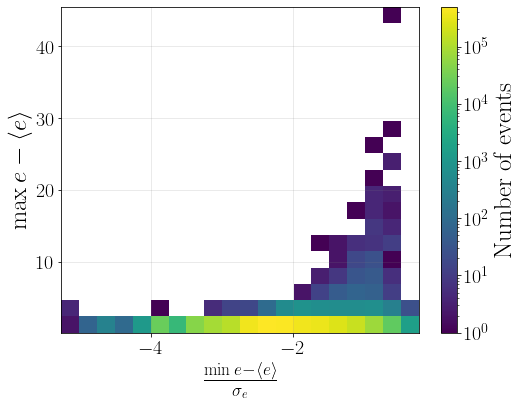

In [34]:
# for name_var1, name_var2 in itertools.combinations(
#     cut_variables + ['max_m_mean'], 2):
name_var2 = "max_m_mean"
for name_var1 in cut_variables:
    min_max = [None, None]
    bins = [None, None]

    if name_var1 in column_ranges:
        min_max[0] = column_ranges[name_var1]
    if name_var2 in column_ranges:
        min_max[1] = column_ranges[name_var2]

    bins[0] = column_nbins.get(name_var1, column_nbins['default'])
    bins[1] = column_nbins.get(name_var2, column_nbins['default'])

    if bins==[None, None]:
        bins = None


    lp.plot_hist2d(
        dataframe_wh_peak[name_var1], dataframe_wh_peak[name_var2],
        column_labels[name_var1], column_labels[name_var2],
        logscale=True,
        min_max=min_max,
        bins=bins
    )

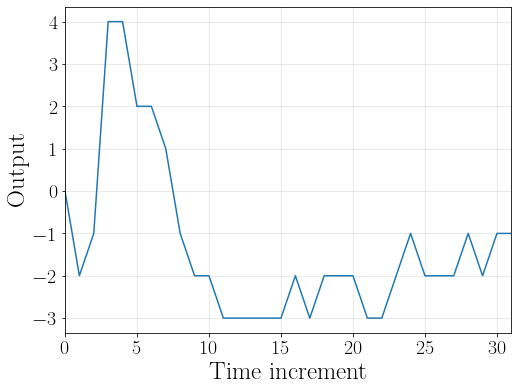

In [46]:
one_event = dataframe_wh_peak.query("max_m_mean > 5 and nb_ampl_sup_80 > 1").iloc[1]
fig, ax = lp.plot_event(
    one_event[defs.list_samples_columns] - one_event['pedestal'],
)


### Cut on $n_{max}$

In [23]:
dataframe_wh_peak_1 = dataframe_wh_peak.query("nb_max==1")
dataframe_wh_peak_2 = dataframe_wh_peak.query("nb_max==2")

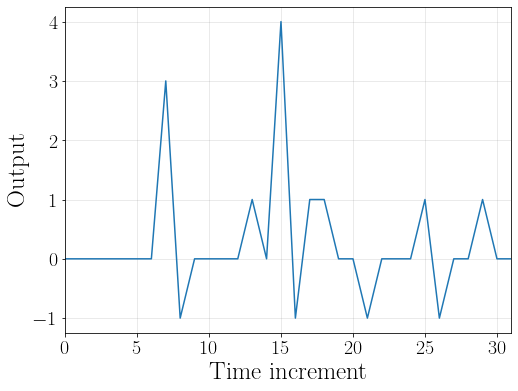

In [29]:
lp.plot_samples_lots(
    dataframe_wh_peak_2.query("max_m_mean > 3"),
    image_path=f"data/{config_name}",
    name="samples_max_m_mean_sup_3_nb_max_2"
)

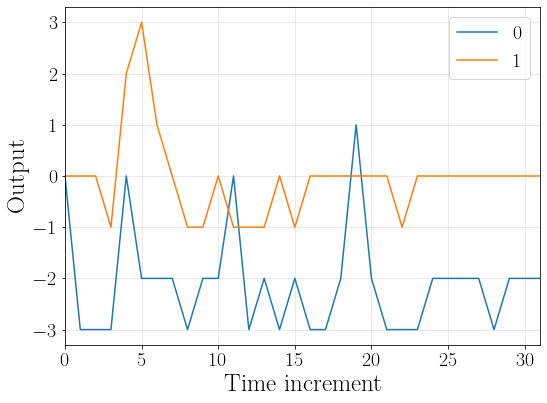

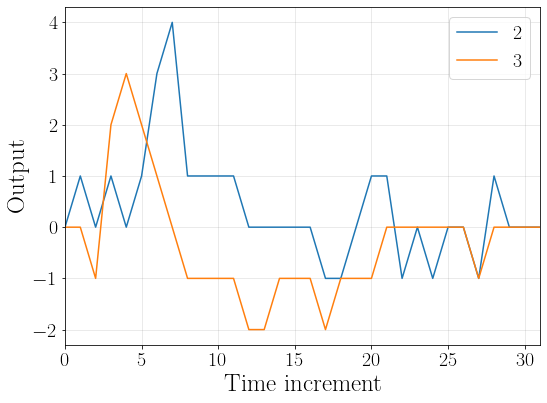

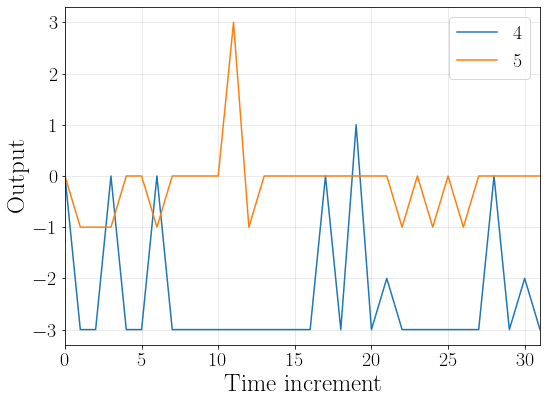

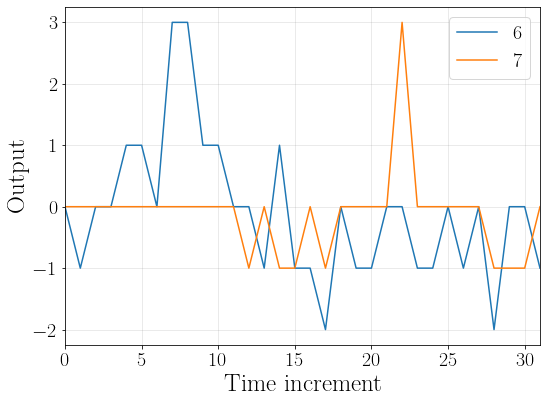

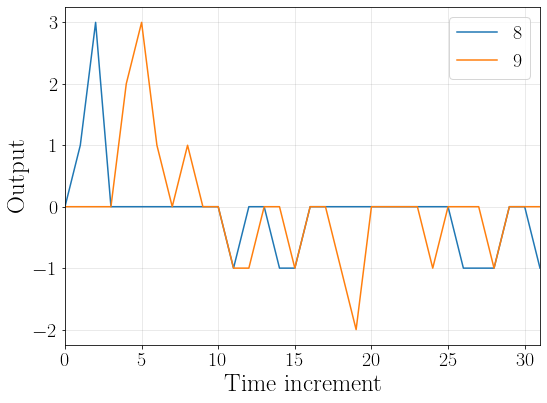

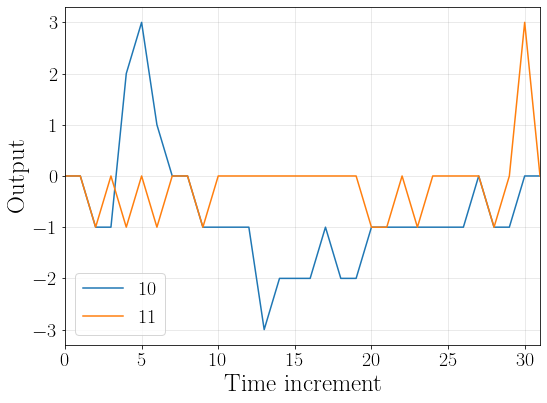

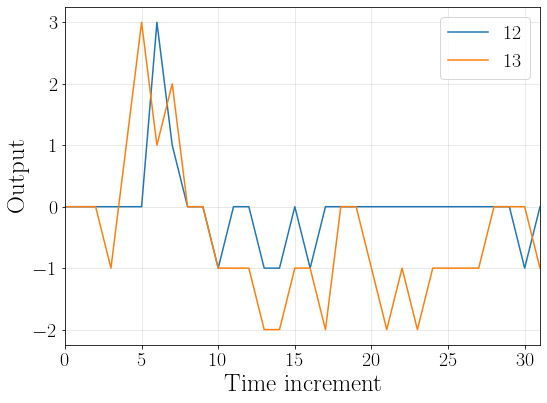

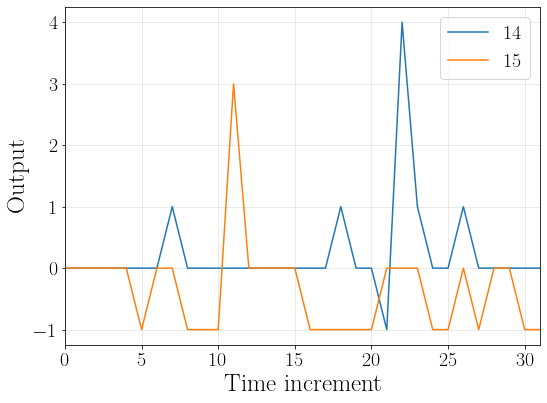

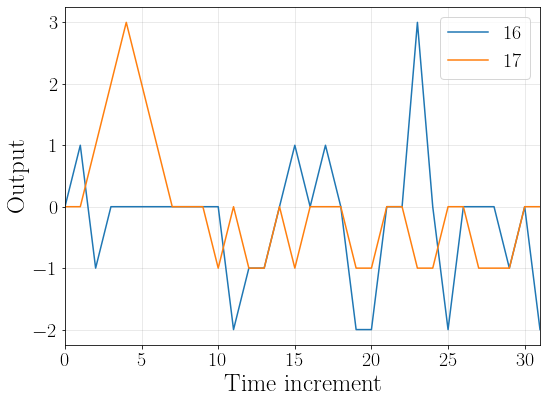

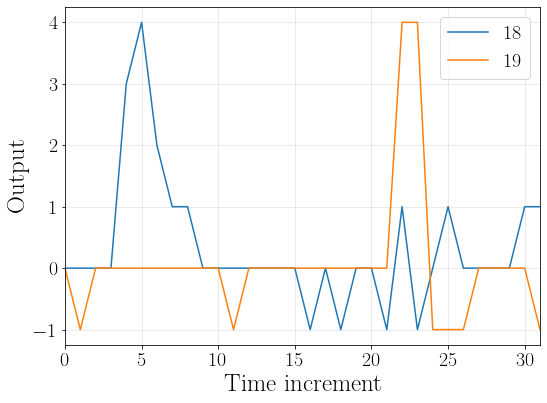

In [38]:
lp.plot_samples_lots(
    dataframe_wh_peak_1.query("max_m_mean > 3 and max_m_mean < 4").sample(20)
)
